#  Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# 1. Loading libraries and dataset

In [2]:
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as ss
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import prettytable
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer
import re # Go to https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

ImportError: cannot import name 'cross_validation' from 'sklearn' (C:\Users\nihar\Anaconda3\lib\site-packages\sklearn\__init__.py)

In [3]:
#Loading the dataset that we cleaned in TSNE project
df = pd.read_csv('affrd_cleaned_preprocessed.csv')

In [4]:
df['Score'].value_counts() #counting the number of positive and negative datapoints

positive    307061
negative     57110
Name: Score, dtype: int64

In [5]:
#randomly sampling positive and negative datapoints and from the dataframe 'df' and creating new data frame total_points
#positive_points = df[df['Score'] == 'positive'].sample(n=20000, random_state=0)#randomly sampling 20k positive points
#negative_points = df[df['Score'] == 'negative'].sample(n=20000, random_state=0)# randomly sampling 20k negative points
#total_points = pd.concat([positive_points, negative_points])#concatenating the positive_points and negative_points dataframe

# Sorting based on time
#sorted_data = total_points.sort_values('Time', #Here we are sorting filtered_data according to Time in 
#                                        axis = 0,    #- ascending order so that we can do time based splitting later.
#                                        ascending = True,
#                                        inplace = False, #inpace = false because we dont want to make modifications in-
#                                        #- fitered data rather we want to keep filtered_data preserved and store the modified-
                                        #- data in sorted_data
#                                        kind = 'quicksort',
#                                        na_position = 'last')
#sorted_data['Score'].value_counts()
#sorted_data.to_csv('sorted_data_df.csv')
sorted_data = pd.read_csv('sorted_data_df.csv')

In [6]:
d_train = sorted_data.iloc[0:20000] #taking top 20k data points from sorted_data and storing it in d_trin
d_cv = sorted_data.iloc[20000:30000]#taking next 20k data points from sorted_data and storing it in d_cv
d_test = sorted_data.iloc[30000:40000]#taking last 20k data points from sorted_data and storing it in d_test

In [7]:
#storing my 'cleaned text' column in d_train into datapoint matrix x_train and 'Score' column in d_train into y_train-
#- and similar thing we are doing for d_cv and d_test
x_train = d_train['CleanedText']
y_train = d_train['Score']
x_cv = d_cv['CleanedText']
y_cv = d_cv['Score']
x_test = d_test['CleanedText']
y_test = d_test['Score']

# 2. Bag of words (BOW)

## 2.1 KNN on BOW's using brute force

In [8]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer = CountVectorizer() #defining our BOW model here.
model = vectorizer.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'pardon': 11401, 'pie': 11790, 'kavalacton': 8490, 'ziwi': 18038, 'grimi': 6852, 'olympia': 10961, 'toothach': 16148, 'experi': 5448, 'messeng': 9796, 'lemon': 8919, 'unclear': 16583, 'ambrosia': 504, 'bravo': 1857, 'caregiv': 2393, 'reluct': 13071, 'sledgehamm': 14371, 'beaten': 1266, 'steal': 14983, 'chees': 2691, 'pomengranit': 12051, 'oatcak': 10841, 'wait': 17279, 'strainer': 15099, 'absorb': 45, 'cheap': 2667, 'voy': 17246, 'acrid': 122, 'pellegrino': 11578, 'allerg': 408, 'ahoy': 307, 'ooffe': 10998, 'tumbl': 16411, 'retent': 13215, 'agav': 268, 'nora': 10680, 'eekkkkk': 4967, 'boarder': 1667, 'purrin': 12579, 'dale': 3898, 'belgium': 1346, 'autism': 968, 'chun': 2897, 'luckili': 9234, 'edmund': 4959, 'potti': 12165, 'grasshopp': 6791, 'availabol': 987, 'rind': 13319, 'row': 13471, 'dent': 4184, 'recompend': 12908, 'massey': 9567, 'fanta': 5570, 'saddl': 13548, 'divis': 4590, 'petstor': 11704, 'kittykatkhan': 8618, 'cast': 2461, 'subsidiari': 15219, 'sphynx': 14765, 'decaff': 4

In [9]:
train_bow = model.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [10]:
#here we are creating a dataframe out of train_bow,cv_bow nd test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model.get_feature_names())

In [11]:
#Here we are standardizing dataframes train_bow_df, cv_bow_df and test_bow_df
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [12]:
#Here we are doing simple cross validation to find out best k value for our dataset. We are finding the best value of k-
#- using a metric called confusion matrix, because confusion matrix tells us about performance of our model more accurately-
#- than 'accuracy' when our dataset is imbalanced and as we saw above that our dataset is imbalanced thats why we are-
#- using confusion matrix as our performance metric.
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=8) #here we are defining our knn model, the algorithm-
    #- we are using is 'brute force'. 'Brute force' works like this:
    #- Step 1: Compute all the distances between the query point and reference points.
    #- Step 2: Sort the computed distances.
    #- Step 3: Select the k reference points with the smallest distances.
    #- Step 4: Classification vote by k nearest objects.
    #- Step 5: Repeat steps (1 to 4) for all query points.
    #- We will run the loop for various values of nearest neighbours and we will run this algorithm parallely on 8 cores.
    knn.fit(standardized_train,y_train) #here we are learning the model on standardized training dataset
    pred = knn.predict(standardized_cv) #here we are predicting the class labels of standardized cv dataset-
    #- using the learned knn model.
    co_mt = confusion_matrix(y_cv,pred) #here we are defining our confusion matrix by comparing actual y_cv with predicted y_cv
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100 #here we are calculating True Negative Ratio (TNR)
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100 #here we are calculating False Positive Ratio (FPR)
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100 #here we are calculating True Positive Ratio (TPR)
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100 #here we are calculating False Negative Ratio (FNR)
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 71.12390701642141, TNR = 49.38806251176803, FPR = 50.61193748823197, FNR = 28.876092983578587

For k = 3, the TPR = 82.08573256557902, TNR = 41.743551120316326, FPR = 58.256448879683674, FNR = 17.914267434420985

For k = 5, the TPR = 87.03348261889529, TNR = 34.66390510261721, FPR = 65.3360948973828, FNR = 12.966517381104714

For k = 7, the TPR = 90.76562166773299, TNR = 28.31858407079646, FPR = 71.68141592920354, FNR = 9.234378332267008

For k = 9, the TPR = 93.43143527404564, TNR = 23.762003389192245, FPR = 76.23799661080776, FNR = 6.568564725954361

For k = 11, the TPR = 95.05224994668373, TNR = 20.203351534550933, FPR = 79.79664846544907, FNR = 4.947750053316272

For k = 13, the TPR = 96.2038814246108, TNR = 17.435511203163244, FPR = 82.56448879683676, FNR = 3.796118575389209

For k = 15, the TPR = 96.77969716357431, TNR = 15.30785162869516, FPR = 84.69214837130484, FNR = 3.2203028364256774

For k = 17, the TPR = 97.35551290253785, TNR = 14.15929203539823, FPR

## Observation:
#### 1. As we can see from above that for k = 3 we are getting highest values of TPR and TNR. Therefore we will select k = 3 as our best value. 
#### 2. We are not selecting k = 1 as our best k inspite of it giving us highest values because that value of k will result in overfitting and our model will be prone to outliers.

In [13]:
#From above simple cross validation we got the best k = 3. Therefore we will now use that value of k and define our new-
#- knn model and then fit it on our train dataset and then predict our y_test
knn = KNeighborsClassifier(n_neighbors=3,algorithm='brute',n_jobs=8)# defining our knn model with no. of nearest neighbours = 3-
#- and using again 'brute' algorithm and no of parallel jobs = 8
knn.fit(standardized_train,y_train) #learning our model using standardized_train and y_train
pred = knn.predict(standardized_test)#predicting our y_test using learned model
co_mt = confusion_matrix(y_test,pred)#defining our confusion matrix
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100 #computing TNR, FPR, TPR and FNR resp.
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 3 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 3 on test data:,
TPR = 81.55216284987277, TNR = 41.21877365632097, FPR = 58.78122634367903, FNR = 18.447837150127228


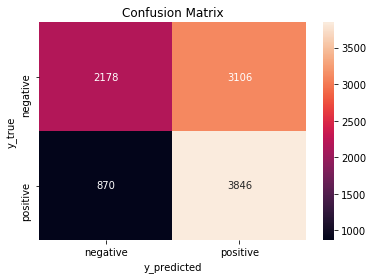

In [14]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 2178, False Positive = 3106, False Negative = 870 and True Positive = 3846.

## 2.2 KNN on BOW's using KD Tree force

In [24]:
#Bag of words
#Applying Bag of words on train datapoint dataset 'x_train'
vectorizer_1 = CountVectorizer(min_df = 50,max_features = 2000,ngram_range = (1,2)) #defining our BOW model here, we are saying here-
#- that we want to consider only those words in our dictionary which occur atleast 50 times in our document and max.-
#- features that we want for our BOW matrix  = 2000
model_1 = vectorizer_1.fit(x_train)#learning the internal parameters (here vocabulary) of text(i.e reviews) in x_train
print(vectorizer.vocabulary_) #visulaizing the vocabulary

{'pardon': 11401, 'pie': 11790, 'kavalacton': 8490, 'ziwi': 18038, 'grimi': 6852, 'olympia': 10961, 'toothach': 16148, 'experi': 5448, 'messeng': 9796, 'lemon': 8919, 'unclear': 16583, 'ambrosia': 504, 'bravo': 1857, 'caregiv': 2393, 'reluct': 13071, 'sledgehamm': 14371, 'beaten': 1266, 'steal': 14983, 'chees': 2691, 'pomengranit': 12051, 'oatcak': 10841, 'wait': 17279, 'strainer': 15099, 'absorb': 45, 'cheap': 2667, 'voy': 17246, 'acrid': 122, 'pellegrino': 11578, 'allerg': 408, 'ahoy': 307, 'ooffe': 10998, 'tumbl': 16411, 'retent': 13215, 'agav': 268, 'nora': 10680, 'eekkkkk': 4967, 'boarder': 1667, 'purrin': 12579, 'dale': 3898, 'belgium': 1346, 'autism': 968, 'chun': 2897, 'luckili': 9234, 'edmund': 4959, 'potti': 12165, 'grasshopp': 6791, 'availabol': 987, 'rind': 13319, 'row': 13471, 'dent': 4184, 'recompend': 12908, 'massey': 9567, 'fanta': 5570, 'saddl': 13548, 'divis': 4590, 'petstor': 11704, 'kittykatkhan': 8618, 'cast': 2461, 'subsidiari': 15219, 'sphynx': 14765, 'decaff': 4

In [25]:
train_bow = model_1.transform(x_train)#converting the internal parameters(i.e vocab) into vectors
cv_bow = model_1.transform(x_cv)# using the same vocab of x_train I am transforming the text in x_cv into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow
test_bow = model_1.transform(x_test)# using the same vocab of x_train I am transforming the text in x_test into bow matrix-
#- in order to maintain the same dimension of matrix as train_bow

In [26]:
#here we are first creating a dataframe out of train_bow, cv_bow and test_bow
train_bow_df = pd.DataFrame(train_bow.toarray(),columns = model_1.get_feature_names())
cv_bow_df = pd.DataFrame(cv_bow.toarray(),columns = model_1.get_feature_names())
test_bow_df = pd.DataFrame(test_bow.toarray(),columns = model_1.get_feature_names())

In [27]:
#Creating Standardized matrices for train, cv and test
standardized_train = StandardScaler().fit_transform(train_bow_df)
standardized_cv = StandardScaler().fit_transform(cv_bow_df)
standardized_test = StandardScaler().fit_transform(test_bow_df)

In [28]:
pca = decomposition.PCA() #defining our PCA

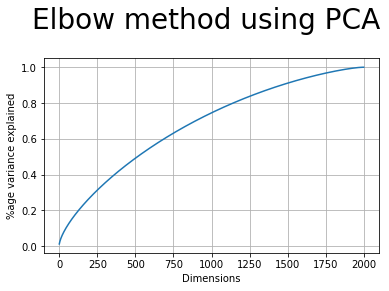

In [29]:
#here we are trying to understand how much variane is explained by 'n' number of dimensions.
pca.n_components = 2000 
X_ = pca.fit_transform(standardized_train)
pca_explained_var = pca.explained_variance_/sum(pca.explained_variance_)
cum_sum_variance = np.cumsum(pca_explained_var)
plt.plot(cum_sum_variance)
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('Elbow method using PCA',size = 28)
plt.xlabel('Dimensions')
plt.ylabel('%age variance explained')
plt.grid()
plt.show()

# Observation
#### We can see from above chart that more than 90% of variance is explained by 1700 dimensions. Now we will create dense matrices out of sparse matrices that we got using  bag of words by considering only these 1700 dimensions and by using truncated SVD.

In [30]:
#As we saw above that more than 90% variance is explained by 1700 dimensions therefore we are taking 1700 dimensions out of-
#- 2000 dimensions and defining our truncated SVD model so that it can convert 2000 dimensional sparse matrix created by-
#- BOW into 1700 dimensional dense matrix.
tsvd = TruncatedSVD(n_components= 1700, algorithm='randomized', n_iter=5, random_state=0) #defining our truncated svd model
x_fit = tsvd.fit(standardized_train)#learning the model on standardized training dataset

In [31]:
#here we are transforming standardized training sparse matrix, standardized cv sparse matrix, standardized test sparse matrix-
#- created by bow into dense matrices
x_tr = x_fit.transform(standardized_train)
x_c = x_fit.transform(standardized_cv)
x_te = x_fit.transform(standardized_test)

In [32]:
#performing simple sross validation using knn with algorithm as kd-tree which is based on simple binary search tree but-
#- is used for dataset with multiple features.
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=8)# defining our knn model
    knn.fit(x_tr,y_train) #learning the model on training dataset
    pred = knn.predict(x_c) # predicting y_cv using learned model
    co_mt = confusion_matrix(y_cv,pred) #defining confusion matrix
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100# calculating TNR, TPR, FPR, FNR
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 72.93666026871402, TNR = 52.250047072114484, FPR = 47.749952927885516, FNR = 27.06333973128599

For k = 3, the TPR = 78.50287907869482, TNR = 52.85257013745057, FPR = 47.14742986254943, FNR = 21.497120921305182

For k = 5, the TPR = 82.14971209213053, TNR = 51.21446055356807, FPR = 48.78553944643193, FNR = 17.85028790786948

For k = 7, the TPR = 84.85817871614417, TNR = 48.74788175484843, FPR = 51.252118245151564, FNR = 15.141821283855833

For k = 9, the TPR = 86.64960545958627, TNR = 47.373376012050464, FPR = 52.626623987949536, FNR = 13.350394540413735

For k = 11, the TPR = 88.09980806142035, TNR = 46.28130295612879, FPR = 53.71869704387121, FNR = 11.900191938579654

For k = 13, the TPR = 89.69929622520793, TNR = 44.398418376953494, FPR = 55.601581623046506, FNR = 10.300703774792067

For k = 15, the TPR = 90.59500959692899, TNR = 42.609678026736965, FPR = 57.390321973263035, FNR = 9.404990403071018

For k = 17, the TPR = 91.83194711025806, TNR = 40.482018452268

## Observation:
#### 1. As we can see from above that for k = 5 we are getting highest values of TPR and TNR. Therefore we will select k = 5 as our best value. 
#### 2. We are not selecting k = 1 as our best k inspite of it giving us highest values because that value of k will result in overfitting and our model will be prone to outliers.

In [33]:
#From above we found the best value of k = 5. Therefor we will now test our model on our test dataset.
knn = KNeighborsClassifier(n_neighbors=5,algorithm='kd_tree',n_jobs=8) #defining our knn model for k=3
knn.fit(x_tr,y_train)#learning our model using training dataset
pred = knn.predict(x_te)#predicting y_test using learned model
co_mt = confusion_matrix(y_test,pred)#defining our confusion matrix
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100 #computing TNR,FPR, TPR and FNR
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 5 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 5 on test data:,
TPR = 81.89143341815097, TNR = 48.69417108251325, FPR = 51.30582891748675, FNR = 18.108566581849026


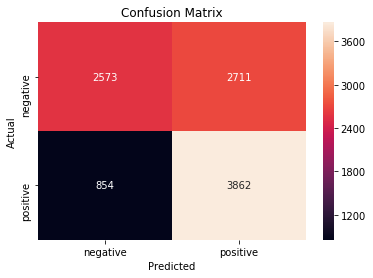

_____________________________________________________________________________________________________


In [34]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
print("_" * 101)

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 2573, False Positive = 2711, False Negative = 854 and True Positive = 3862.

# 3 TF-IDF

## 3.1 KNN on TFIDF using Brute Force

In [35]:
#tf-idf on train dataset
vectorizer = TfidfVectorizer()#defining our tf-idf model
model = vectorizer.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'pardon': 11401, 'pie': 11790, 'kavalacton': 8490, 'ziwi': 18038, 'grimi': 6852, 'olympia': 10961, 'toothach': 16148, 'experi': 5448, 'messeng': 9796, 'lemon': 8919, 'unclear': 16583, 'ambrosia': 504, 'bravo': 1857, 'caregiv': 2393, 'reluct': 13071, 'sledgehamm': 14371, 'beaten': 1266, 'steal': 14983, 'chees': 2691, 'pomengranit': 12051, 'oatcak': 10841, 'wait': 17279, 'strainer': 15099, 'absorb': 45, 'cheap': 2667, 'voy': 17246, 'acrid': 122, 'pellegrino': 11578, 'allerg': 408, 'ahoy': 307, 'ooffe': 10998, 'tumbl': 16411, 'retent': 13215, 'agav': 268, 'nora': 10680, 'eekkkkk': 4967, 'boarder': 1667, 'purrin': 12579, 'dale': 3898, 'belgium': 1346, 'autism': 968, 'chun': 2897, 'luckili': 9234, 'edmund': 4959, 'potti': 12165, 'grasshopp': 6791, 'availabol': 987, 'rind': 13319, 'row': 13471, 'dent': 4184, 'recompend': 12908, 'massey': 9567, 'fanta': 5570, 'saddl': 13548, 'divis': 4590, 'petstor': 11704, 'kittykatkhan': 8618, 'cast': 2461, 'subsidiari': 15219, 'sphynx': 14765, 'decaff': 4

In [36]:
train_tfidf = model.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model.transform(x_cv) #here we are using the internal parameters we learnt above to convert our reviews in x_cv into-
#- matrices
test_tfidf = model.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [37]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model.get_feature_names())

In [38]:
#here we are creating standardized train, standardized cv and standardized test matrices
standardized_train_tfidf = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv_tfidf = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test_tfidf = StandardScaler().fit_transform(test_tfidf_df)

In [39]:
standardized_test_tfidf.shape

(10000, 18063)

In [40]:
#performing simple cross validation using brute algorithm of knn and calculating TPR, TNR, FPR and FNR
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=8)# defining our knn model
    knn.fit(standardized_train_tfidf,y_train)
    pred = knn.predict(standardized_cv_tfidf)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 75.45318831307316, TNR = 38.486160798343064, FPR = 61.513839201656936, FNR = 24.54681168692685

For k = 3, the TPR = 88.71827681808489, TNR = 23.215966861231408, FPR = 76.78403313876859, FNR = 11.28172318191512

For k = 5, the TPR = 94.90296438473021, TNR = 13.123705516851816, FPR = 86.87629448314819, FNR = 5.09703561526978

For k = 7, the TPR = 97.78204307954788, TNR = 6.966672942948597, FPR = 93.03332705705141, FNR = 2.217956920452122

For k = 9, the TPR = 98.97632757517594, TNR = 3.7657691583505932, FPR = 96.2342308416494, FNR = 1.0236724248240563

For k = 11, the TPR = 99.57346982298998, TNR = 1.8075691960082847, FPR = 98.19243080399171, FNR = 0.42653017701002344

For k = 13, the TPR = 99.8507144380465, TNR = 0.6966672942948597, FPR = 99.30333270570515, FNR = 0.1492855619535082

For k = 15, the TPR = 99.914693964598, TNR = 0.3954057616268123, FPR = 99.6045942383732, FNR = 0.08530603540200468

For k = 17, the TPR = 99.9786734911495, TNR = 0.18828845791752966, F

## Observation:
#### 1. As we can see from above that for k = 3 we are getting highest values of TPR and TNR. Therefore we will select k = 3 as our best value. 
#### 2. We are not selecting k = 1 as our best k inspite of it giving us highest values because that value of k will result in overfitting and our model will be prone to outliers.

In [41]:
#From above we found the best value of k = 3. Therefor we will now test our model on our test dataset.
knn = KNeighborsClassifier(n_neighbors=3,algorithm='brute',n_jobs=8)
knn.fit(standardized_train_tfidf,y_train)
pred = knn.predict(standardized_test_tfidf)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 3 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 3 on test data:,
TPR = 87.59541984732824, TNR = 23.25889477668433, FPR = 76.74110522331567, FNR = 12.404580152671755


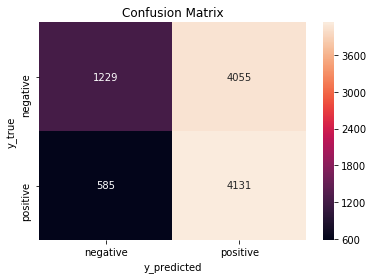

In [42]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 1229, False Positive = 4055, False Negative = 585 and True Positive = 4131.

## 3.1 KNN on TFIDF using  KD Tree

In [43]:
#tf-idf on train dataset
vectorizer_1 = TfidfVectorizer(min_df = 50, max_features = 2000,ngram_range = (1,2))#defining our tf-idf model
model_1 = vectorizer_1.fit(x_train)#Here we are learning the internal parameters (i.e vocabulary) of our train dataset-
#- (i.e. review text)
print(vectorizer_1.vocabulary_) #visualizing the parameters learnt (i.e vocabulary)

{'regret': 1430, 'agav': 25, 'incred': 882, 'sourc': 1607, 'brown rice': 207, 'beauti': 131, 'somewhat': 1597, 'dri': 513, 'sour': 1606, 'rip': 1460, 'chines': 293, 'oili': 1191, 'licoric': 977, 'shop': 1545, 'leav': 967, 'couldnt find': 375, 'black tea': 165, 'honest': 850, 'member': 1090, 'foil': 666, 'tast better': 1717, 'way': 1905, 'sea': 1502, 'gluten free': 731, 'sodium': 1586, 'banana': 118, 'smell': 1577, 'mom': 1121, 'doubl': 506, 'sever': 1529, 'coffe bean': 322, 'salt': 1484, 'ginger': 720, 'someon': 1592, 'give one': 724, 'ad': 11, 'unless': 1851, 'sound like': 1604, 'tran fat': 1809, 'chocol tast': 299, 'link': 997, 'wow': 1975, 'temperatur': 1740, 'huge': 863, 'benefit': 143, 'hair': 800, 'chunk': 306, 'develop': 451, 'supermarket': 1688, 'pain': 1243, 'order product': 1223, 'near': 1150, 'guy': 798, 'scienc': 1499, 'preserv': 1326, 'trader': 1804, 'boy': 190, 'buy amazon': 221, 'bland': 166, 'valu': 1865, 'definit': 432, 'gross': 787, 'purpos': 1373, 'plan': 1290, 'grai

In [44]:
train_tfidf = model_1.transform(x_train)#here we are using the internal parameters we learnt above to convert our reviews 
#- in x_train into matrices
cv_tfidf = model_1.transform(x_cv) #here we are using the internal parameters we learnt above to convert our reviews in x_cv into-
#- matrices
test_tfidf = model_1.transform(x_test)#here we are using the internal parameters we learnt above to convert our reviews in 
#- x_test into matrices

In [45]:
#here we are first creating a dataframes out of train_tfidf, cv_tfidf and test_tfidf 
train_tfidf_df = pd.DataFrame(train_tfidf.toarray(),columns = model_1.get_feature_names())
cv_tfidf_df = pd.DataFrame(cv_tfidf.toarray(),columns = model_1.get_feature_names())
test_tfidf_df = pd.DataFrame(test_tfidf.toarray(),columns = model_1.get_feature_names())

In [46]:
#Here we are standardizing our dataframes created above
standardized_train_tfidf = StandardScaler().fit_transform(train_tfidf_df)
standardized_cv_tfidf = StandardScaler().fit_transform(cv_tfidf_df)
standardized_test_tfidf = StandardScaler().fit_transform(test_tfidf_df)

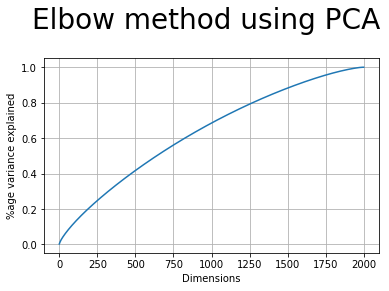

In [47]:
#here we are trying to understand how much variane is explained by 'n' number of dimensions.
pca.n_components = 2000
X_ = pca.fit_transform(standardized_train_tfidf)
pca_explained_var = pca.explained_variance_/sum(pca.explained_variance_)
cum_sum_variance = np.cumsum(pca_explained_var)
plt.plot(cum_sum_variance)
plt.subplots_adjust(top=0.8, wspace = 0.6)
plt.suptitle('Elbow method using PCA',size = 28)
plt.xlabel('Dimensions')
plt.ylabel('%age variance explained')
plt.grid()
plt.show()

# Observation
#### We can see from above chart that more than 90% of variance is explained by 1750 dimensions. Now we will create dense matrices out of sparse matrices that we got using  bag of words by considering only these 1750 dimensions and by using truncated SVD.

In [48]:
#As we saw above that more than 90% variance is explained by 1750 dimensions therefore we are taking 1750 dimensions out of-
#- 2000 dimensions and defining our truncated SVD model so that it can convert 2000 dimensional sparse matrix created by-
#- tfidf into 1750 dimensional dense matrix.
tsvd = TruncatedSVD(n_components= 1750, algorithm='randomized', n_iter=5, random_state=0)
x_fit = tsvd.fit(standardized_train_tfidf)

In [49]:
#here we are transforming standardized training sparse matrix, standardized cv sparse matrix, standardized test sparse matrix-
#- created by bow into dense matrices
x_tr = x_fit.transform(standardized_train_tfidf)
x_c = x_fit.transform(standardized_cv_tfidf)
x_te = x_fit.transform(standardized_test_tfidf)

In [50]:
#performing simple sross validation using knn with algorithm as kd-tree which is based on simple binary search tree but-
#- is used for dataset with multiple features and then calculating TPR,TNR, FPR and FNR
for i in range(1,30,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=8)# defining our knn model
    knn.fit(x_tr,y_train)
    pred = knn.predict(x_c)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 83.21603753465557, TNR = 27.132366785916023, FPR = 72.86763321408398, FNR = 16.783962465344423

For k = 3, the TPR = 91.74664107485604, TNR = 16.776501600451894, FPR = 83.2234983995481, FNR = 8.253358925143955

For k = 5, the TPR = 94.28449562806568, TNR = 14.705328563359066, FPR = 85.29467143664094, FNR = 5.715504371934315

For k = 7, the TPR = 96.03326935380679, TNR = 13.142534362643572, FPR = 86.85746563735644, FNR = 3.966730646193218

For k = 9, the TPR = 96.6304116016208, TNR = 12.25757861043118, FPR = 87.74242138956882, FNR = 3.3695883983791854

For k = 11, the TPR = 97.22755384943484, TNR = 11.184334400301262, FPR = 88.81566559969873, FNR = 2.7724461505651528

For k = 13, the TPR = 97.59010449989337, TNR = 9.998117115420825, FPR = 90.00188288457917, FNR = 2.4098955001066327

For k = 15, the TPR = 97.86734911494989, TNR = 9.433251741668236, FPR = 90.56674825833177, FNR = 2.1326508850501176

For k = 17, the TPR = 98.31520580081042, TNR = 8.736584447373376, FP

## Observation:
#### 1. As we can see from above that for k = 3 we are getting highest values of TPR and TNR. Therefore we will select k = 3 as our best value. 
#### 2. We are not selecting k = 1 as our best k inspite of it giving us highest values because that value of k will result in overfitting and our model will be prone to outliers.

In [51]:
#From above we got best value of k = 3 (we didnt choose k = 1 because it may lead to overfitting) and now we will test that-
#- model on our test dataset
knn = KNeighborsClassifier(n_neighbors=3,algorithm='kd_tree',n_jobs=8)
knn.fit(x_tr,y_train)
pred = knn.predict(x_te)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 3 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 3 on test data:,
TPR = 91.6242578456319, TNR = 15.10219530658592, FPR = 84.89780469341409, FNR = 8.375742154368108


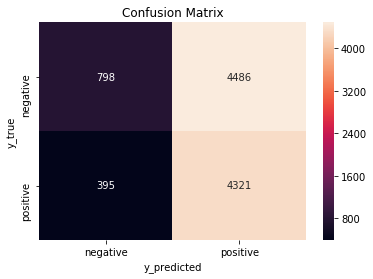

In [52]:
#plotting our confusion mtrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 798, False Positive = 4486, False Negative = 395 and True Positive = 4321.

# 4. Word2Vec

In [53]:
#splitting each of my reviews in x_train into list of, list of stemmed words in each of our stemmed reviews in x_train
list_of_sent = []
for sent in x_train.values:
    list_of_sent.append(sent.split())

In [54]:
#splitting each of my reviews in x_cv into list of, list of stemmed words in each of our stemmed reviews in x_cv
list_of_sent_cv = []
for sent in x_cv.values:
    list_of_sent_cv.append(sent.split())

In [55]:
#splitting each of my reviews in x_test into list of, list of stemmed words in each of our stemmed reviews in x_test
list_of_sent_test = []
for sent in x_test.values:
    list_of_sent_test.append(sent.split())

In [56]:
w2v_model = Word2Vec(list_of_sent,min_count = 5,size = 50,workers = 4) #Here I am creating word2vec representation of each of-
#- the words in my 'list_of_sent' list i.e I am creating w2v representation of words in reviews of x_train, where we-
#- are creating word2vec vectors for words in 'list_of_sent' list which-
#- occur >=5 times in the list. The number of dimensions of our word2ec vectors = 50 and number of cores which will carry-
#- on the job parallely = 4
print(w2v_model) #returns an iterator
#to see which words exist in our w2v-model
w2v_words = list(w2v_model.wv.vocab)#Here we are creating list of words, which are keys in dictionary 'w2v_model.wv.vocab'.
print(w2v_words)

Word2Vec(vocab=6407, size=50, alpha=0.025)
['pie', 'alley', 'triglycerid', 'honeyvill', 'conagra', 'bout', 'vernor', 'fix', 'cave', 'aromat', 'experi', 'lemon', 'unclear', 'bravo', 'reluct', 'bengal', 'beaten', 'flea', 'steal', 'diaper', 'chees', 'transplant', 'strainer', 'appetit', 'absorb', 'bought', 'cheap', 'acrid', 'gasket', 'ikea', 'earn', 'devil', 'allerg', 'ahoy', 'lamp', 'creami', 'picki', 'repair', 'yep', 'oolong', 'via', 'readili', 'teeccino', 'barbecu', 'effici', 'certifi', 'belgium', 'dragon', 'autism', 'achiev', 'luckili', 'potti', 'paprika', 'rind', 'row', 'dent', 'noth', 'baffl', 'grip', 'marinara', 'school', 'indiffer', 'call', 'shred', 'decaff', 'suppli', 'grey', 'parboil', 'thin', 'asia', 'scrape', 'lori', 'form', 'gadget', 'cracker', 'motel', 'outlet', 'gardenia', 'buffet', 'portland', 'unrol', 'skinni', 'korean', 'tech', 'effort', 'esp', 'couch', 'tough', 'dosent', 'born', 'besid', 'submit', 'chana', 'swim', 'stray', 'rubbish', 'bloat', 'contempl', 'bubblegum', 'mr

## 4.1 Average Word2Vec

In [57]:
#average word2vec for each review in x_train
sent_vectors = []
for sent in tqdm(list_of_sent): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_train
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 20000/20000 [01:16<00:00, 262.97it/s]

20000
50


In [58]:
#average word2vec for each review in x_cv
sent_vectors_cv = []
for sent in tqdm(list_of_sent_cv): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_cv'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_cv
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 10000/10000 [00:38<00:00, 256.41it/s]

10000
50


In [59]:
#average word2vec for each review in x_test
sent_vectors_test = []
for sent in tqdm(list_of_sent_test): #tqdm displays a progress bar. The progress bar tells us the rate at which-
    #-the looping operation is taking place
    sent_vec = np.zeros(50)# here we are creating numpy array of 50 zeros
    cnt_words = 0; #this variable will be used to count the number of words in each element (which is a list) of 'list_of_sent_test'
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]#here we are storing the word2vec representation of each word in sent-
            #- which is in 'w2v_words' list
            sent_vec += vec #here we are adding all the w2v vectors for each word in a review(or sent)
            cnt_words +=1
    if cnt_words!=0:
        sent_vec/=cnt_words #here we are calculating average w2v for each review(or sent) in x_test
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 10000/10000 [00:39<00:00, 254.83it/s]

10000
50


In [60]:
#here we are first creating a dataframe out of sent_vectors, sent_vectors_cv, sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(sent_vectors)
tfidf_w2v_cv = pd.DataFrame(sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(sent_vectors_test)

In [61]:
#here we are standardizing the train, cv and test dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

## 4.1.1 KNN on average Word2Vec using brute force

In [62]:
#here we are performing simple cross validation using brute force algorithm for various values of k and then calculating-
#- TPR, TNR, FPR and FNR for each of the k values.
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=8)
    knn.fit(standardized_train,y_train)
    pred = knn.predict(standardized_cv)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 73.40584346342503, TNR = 68.27339484089624, FPR = 31.726605159103748, FNR = 26.594156536574964

For k = 3, the TPR = 77.86308381317978, TNR = 71.38015439653549, FPR = 28.619845603464505, FNR = 22.13691618682022

For k = 5, the TPR = 79.84644913627639, TNR = 72.75466013933347, FPR = 27.24533986066654, FNR = 20.153550863723606

For k = 7, the TPR = 80.29430582213692, TNR = 73.86556204104689, FPR = 26.134437958953114, FNR = 19.705694177863084

For k = 9, the TPR = 81.04073363190446, TNR = 74.20448126529844, FPR = 25.79551873470156, FNR = 18.95926636809554

For k = 11, the TPR = 81.29665173811047, TNR = 74.67520241009225, FPR = 25.32479758990774, FNR = 18.70334826188953

For k = 13, the TPR = 81.29665173811047, TNR = 74.52457164375824, FPR = 25.475428356241764, FNR = 18.70334826188953

For k = 15, the TPR = 81.70185540627, TNR = 74.5810581811335, FPR = 25.418941818866504, FNR = 18.298144593730008

For k = 17, the TPR = 82.06440605672852, TNR = 74.95763509696856, FPR =

## Observation:
#### 1. As we can see from above that for k = 25 we are getting best values of TPR and TNR. Therefore we will select k = 25 as our best value. 

In [69]:
#From above we found k=33 the best value of k and hence now we will test our model on test dataset
knn = KNeighborsClassifier(n_neighbors=33,algorithm='brute',n_jobs=8)
knn.fit(standardized_train,y_train)
pred = knn.predict(standardized_test)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 33 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 33 on test data:,
TPR = 81.91263782866837, TNR = 73.9780469341408, FPR = 26.0219530658592, FNR = 18.087362171331637


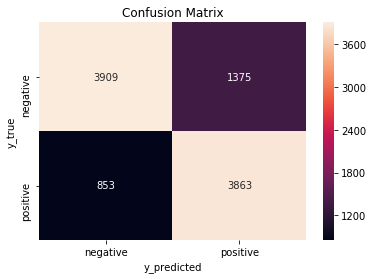

In [70]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 3909, False Positive = 1375, False Negative = 853 and True Positive = 3863.

## 4.1.1 KNN on average Word2Vec using KD Tree

In [71]:
#here we are performing simple cross validation using KD Tree algorithm for various values of k and then calculating-
#- TPR, TNR, FPR and FNR for each of the k values.
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=8)
    knn.fit(standardized_train,y_train)
    pred = knn.predict(standardized_cv)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 73.40584346342503, TNR = 68.27339484089624, FPR = 31.726605159103748, FNR = 26.594156536574964

For k = 3, the TPR = 77.86308381317978, TNR = 71.38015439653549, FPR = 28.619845603464505, FNR = 22.13691618682022

For k = 5, the TPR = 79.84644913627639, TNR = 72.75466013933347, FPR = 27.24533986066654, FNR = 20.153550863723606

For k = 7, the TPR = 80.29430582213692, TNR = 73.86556204104689, FPR = 26.134437958953114, FNR = 19.705694177863084

For k = 9, the TPR = 81.04073363190446, TNR = 74.20448126529844, FPR = 25.79551873470156, FNR = 18.95926636809554

For k = 11, the TPR = 81.29665173811047, TNR = 74.67520241009225, FPR = 25.32479758990774, FNR = 18.70334826188953

For k = 13, the TPR = 81.29665173811047, TNR = 74.52457164375824, FPR = 25.475428356241764, FNR = 18.70334826188953

For k = 15, the TPR = 81.70185540627, TNR = 74.5810581811335, FPR = 25.418941818866504, FNR = 18.298144593730008

For k = 17, the TPR = 82.06440605672852, TNR = 74.95763509696856, FPR =

## Observation:
#### 1. As we can see from above that for k = 25 we are getting highest values of TPR and TNR. Therefore we will select k = 25 as our best value. 

In [72]:
#From above we found k=25 the best value of k and hence now we will test our model on test dataset
knn = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree',n_jobs=8)
knn.fit(standardized_train,y_train)
pred = knn.predict(standardized_test)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 25 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 25 on test data:,
TPR = 81.61577608142494, TNR = 73.8455715367146, FPR = 26.154428463285388, FNR = 18.384223918575064


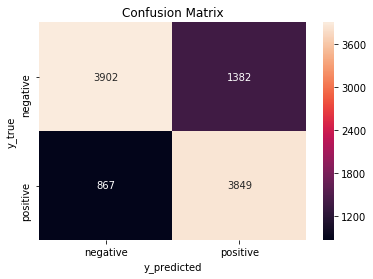

In [73]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 3902, False Positive = 1382, False Negative = 867 and True Positive = 3849.

## 4.2 Weighted Word2Vec

In [74]:
#creating dictionary, where keys are words in our dataset and values are their corresponding idf values
dictionary_1 = dict(zip(model.get_feature_names(),list(model.idf_)))

In [75]:
#Weighted word2vec for x_train
tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_train))
print(len(tfidf_sent_vectors_train[0]))

100%|██████████| 20000/20000 [01:24<00:00, 255.09it/s]

20000
50


In [76]:
#Weighted word2vec for x_cv
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_cv))
print(len(tfidf_sent_vectors_cv[0]))

100%|██████████| 10000/10000 [00:44<00:00, 225.39it/s]

10000
50


In [77]:
#Weighted word2vec for x_test
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary_1[word]*(sent.count(word)/len(sent)) # dictionary[word] = idf value of word in whole courpus-
            #- sent.count(word) = tf valeus of word in this review 
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print(len(tfidf_sent_vectors_test))
print(len(tfidf_sent_vectors_test[0]))

100%|██████████| 10000/10000 [00:45<00:00, 221.65it/s]

10000
50


In [78]:
#here we are first creating a dataframes out of tfidf_sent_vectors_train, tfidf_sent_vectors_cv and tfidf_sent_vectors_test
tfidf_w2v_tr = pd.DataFrame(tfidf_sent_vectors_train)
tfidf_w2v_cv = pd.DataFrame(tfidf_sent_vectors_cv)
tfidf_w2v_te = pd.DataFrame(tfidf_sent_vectors_test)

In [79]:
#standardizing the dataframes created above
standardized_train = StandardScaler().fit_transform(tfidf_w2v_tr)
standardized_cv = StandardScaler().fit_transform(tfidf_w2v_cv)
standardized_test = StandardScaler().fit_transform(tfidf_w2v_te)

## 4.2.1 KNN on Weighted Word2Vec using brute force

In [80]:
#performing simple cross validation for various values of k using brute force and computing TPR, TNR, FPR and FNR for each-
#- value of k to determine the best k.
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute',n_jobs=8)
    knn.fit(standardized_train,y_train)
    pred = knn.predict(standardized_cv)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 72.10492642354447, TNR = 65.29843720579929, FPR = 34.70156279420071, FNR = 27.895073576455538

For k = 3, the TPR = 75.26124973341865, TNR = 68.27339484089624, FPR = 31.726605159103748, FNR = 24.73875026658136

For k = 5, the TPR = 76.86073789720623, TNR = 68.6123140651478, FPR = 31.387685934852193, FNR = 23.139262102793772

For k = 7, the TPR = 77.41522712731926, TNR = 69.36546789681792, FPR = 30.634532103182078, FNR = 22.58477287268074

For k = 9, the TPR = 78.01236937513329, TNR = 69.2148371304839, FPR = 30.785162869516096, FNR = 21.987630624866707

For k = 11, the TPR = 78.52420558754531, TNR = 69.5349275089437, FPR = 30.4650724910563, FNR = 21.475794412454682

For k = 13, the TPR = 78.63083813179782, TNR = 70.04330634532103, FPR = 29.95669365467897, FNR = 21.369161868202173

For k = 15, the TPR = 78.84410322030284, TNR = 69.91150442477876, FPR = 30.08849557522124, FNR = 21.155896779697166

For k = 17, the TPR = 78.99338878225635, TNR = 69.70438712106947, FPR 

## Observation:
#### 1. As we can see from above that for k = 25 we are getting optimum values of TPR and TNR. Therefore we will select k = 25 as our best value.

In [81]:
#From above we found best value of k = 25, now we will test our model for this value of k.
knn = KNeighborsClassifier(n_neighbors=25,algorithm='brute',n_jobs=8)
knn.fit(standardized_train,y_train)
pred = knn.predict(standardized_test)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 25 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 25 on test data:,
TPR = 78.66836301950806, TNR = 68.8115064345193, FPR = 31.188493565480695, FNR = 21.331636980491943


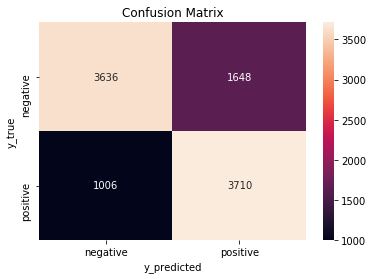

In [82]:
#plotting the confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 3636, False Positive = 1648, False Negative = 1006 and True Positive = 3710.

## 4.2.2 KNN on Weighted Word2Vec using KD Tree

In [86]:
#performing simple cross validation for various values of k using kd tree and computing TPR, TNR, FPR and FNR for each-
#- value of k to determine the best k.
for i in range(1,50,2):
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='kd_tree',n_jobs=8)
    knn.fit(standardized_train,y_train)
    pred = knn.predict(standardized_cv)
    co_mt = confusion_matrix(y_cv,pred)
    TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
    FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
    TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
    FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
    print('\nFor k = {0}, the TPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 1, the TPR = 72.10492642354447, TNR = 65.29843720579929, FPR = 34.70156279420071, FNR = 27.895073576455538

For k = 3, the TPR = 75.26124973341865, TNR = 68.27339484089624, FPR = 31.726605159103748, FNR = 24.73875026658136

For k = 5, the TPR = 76.86073789720623, TNR = 68.6123140651478, FPR = 31.387685934852193, FNR = 23.139262102793772

For k = 7, the TPR = 77.41522712731926, TNR = 69.36546789681792, FPR = 30.634532103182078, FNR = 22.58477287268074

For k = 9, the TPR = 78.01236937513329, TNR = 69.2148371304839, FPR = 30.785162869516096, FNR = 21.987630624866707

For k = 11, the TPR = 78.52420558754531, TNR = 69.5349275089437, FPR = 30.4650724910563, FNR = 21.475794412454682

For k = 13, the TPR = 78.63083813179782, TNR = 70.04330634532103, FPR = 29.95669365467897, FNR = 21.369161868202173

For k = 15, the TPR = 78.84410322030284, TNR = 69.91150442477876, FPR = 30.08849557522124, FNR = 21.155896779697166

For k = 17, the TPR = 78.99338878225635, TNR = 69.70438712106947, FPR 

## Observation:
#### 1. As we can see from above that for k = 25 we are getting optimal values of TPR and TNR. Therefore we will select k = 25 as our best value. 

In [84]:
#From above we found best value of k = 25, now we will test our model for this value of k.
knn = KNeighborsClassifier(n_neighbors=25,algorithm='kd_tree',n_jobs=8)
knn.fit(standardized_train,y_train)
pred = knn.predict(standardized_test)
co_mt = confusion_matrix(y_test,pred)
TNR = (co_mt[0][0]/(co_mt[0][0]+co_mt[0][1]))*100
FPR = (co_mt[0][1]/(co_mt[0][0]+co_mt[0][1]))*100
TPR = (co_mt[1][1]/(co_mt[1][0]+co_mt[1][1]))*100
FNR = (co_mt[1][0]/(co_mt[1][0]+co_mt[1][1]))*100
print('\nFor k = 25 on test data:,\nTPR = {1}, TNR = {2}, FPR = {3}, FNR = {4}'.format(i,TPR,TNR,FPR,FNR))


For k = 25 on test data:,
TPR = 78.66836301950806, TNR = 68.8115064345193, FPR = 31.188493565480695, FNR = 21.331636980491943


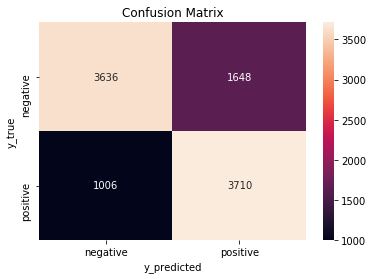

In [85]:
#plotting our confusion matrix
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(co_mt, index=class_label, columns=class_label)
sns.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("y_predicted")
plt.ylabel("y_true")
plt.show()

## Observation:
#### 1. From the confusion matrix for our test dataset above we can see True Negative = 3636, False Positive = 1648, False Negative = 1006 and True Positive = 3710.

# Conclusion

In [90]:
x = prettytable.PrettyTable()
list_1 = [['BOW','Brute',3,81.55216284987277,41.21877365632097,58.78122634367903,18.447837150127228],
         ['BOW','KD Tree',5,81.89143341815097,48.69417108251325,51.30582891748675,18.108566581849026],
         ['TFIDF','Brute',3,87.59541984732824,23.25889477668433,76.74110522331567,12.404580152671755],
         ['TFIDF','KD Tree',3,91.6242578456319,15.10219530658592,84.89780469341409,8.375742154368108],
         ['Average W2V','Brute',33,81.91263782866837,73.9780469341408,26.0219530658592,18.087362171331637],
         ['Average W2V','KD Tree',25,81.61577608142494,73.8455715367146,26.154428463285388,18.384223918575064],
         ['Weighted W2V','Brute',25,78.66836301950806,68.8115064345193,31.188493565480695,21.331636980491943],
         ['Weighted W2V','KD Tree',25,78.66836301950806,68.8115064345193,31.188493565480695,21.331636980491943]]
x.field_names= ['Vectorizer', 'Model', 'Hyperparameter', 'TPR','TNR','FPR','FNR' ]
for i in list_1:
    x.add_row(i)
print(x)

+--------------+---------+----------------+-------------------+-------------------+--------------------+--------------------+
|  Vectorizer  |  Model  | Hyperparameter |        TPR        |        TNR        |        FPR         |        FNR         |
+--------------+---------+----------------+-------------------+-------------------+--------------------+--------------------+
|     BOW      |  Brute  |       3        | 81.55216284987277 | 41.21877365632097 | 58.78122634367903  | 18.447837150127228 |
|     BOW      | KD Tree |       5        | 81.89143341815097 | 48.69417108251325 | 51.30582891748675  | 18.108566581849026 |
|    TFIDF     |  Brute  |       3        | 87.59541984732824 | 23.25889477668433 | 76.74110522331567  | 12.404580152671755 |
|    TFIDF     | KD Tree |       3        |  91.6242578456319 | 15.10219530658592 | 84.89780469341409  | 8.375742154368108  |
| Average W2V  |  Brute  |       33       | 81.91263782866837 |  73.9780469341408 |  26.0219530658592  | 18.0873621713

#### We can see from above table that KNN (using both KD Tree and Brute algorithms) is performing better on Average W2V vector representation of our reviews in determining whether a review is positive or not because the True Positive Ratio and True Negative Ratio values are the highest for it. After that we can see that KNN is performing well on Weighted W2V vector representation of our reviews in determining whether a review is positive or not. KNN is performing worst on TFIDF vector representation of our reviews in determining whether a review is positive or not as its TPR and TNR values are lowest. We also found that KNN using KD Tree on Average W2V uses less number of neighbours(25) to get approximately the same TPR and TNR as KNN using Brute on Average W2V in determining whether a review is positive or not. We could also use other performance measuring techniques like Precision score, F1-score etc. to determine the performance of our KNN model on various vector representation techniques. Also we can use models like Logistic regression, Naive bayes on vector representations of our reviews to determine if a review is positive or not.